# Datasets and DataLoaders

PyTorch provides a way to create your own data via [`torch.utils.data`](https://pytorch.org/docs/stable/data.html) module.

It allows us to:
- Create custom datasets (finite or infinite)
- Quickly load data in batches using multiple processes
- Pin data to GPU memory for faster transfers

## Map-style datasets

Those are the most common datasets and have a really simple structure:
- Create a class by inheriting from [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)
- Override `__init__` (__optionally, if needed__)
- Define `__getitem__(self, index)` method (__responsible for obtaining SINGLE sample__)
- Define `__len__(self)` method (__how many samples are there in total__)

Let's see how this looks in practice:

In [1]:
import typing

import torch


class DummyDataset(torch.utils.data.Dataset):
    def __init__(self, l: typing.List[typing.Any]):
        self.l = l

    # Not dependent on index
    def __getitem__(self, index):
        return self.l[index]

    def __len__(self):
        return len(self.l)


dataset = DummyDataset([0, 1, 2, 3, 4, 5])
len(dataset), dataset[3]

(6, 3)

## Exercise

Create a dataset with `X` data and `y` labels by inheriting from `torch.utils.data.Dataset` (name it `Dataset`).
- Code setup in `__init__(X, y)` (verify that `X` and `y` are of equal length (you can use [`assert`](https://stackoverflow.com/questions/5142418/what-is-the-use-of-assert-in-python) for that)
- In `__getitem__` return `tuple` containing sample and it's respective label defined by `index`
- In `__len__` return how many samples are contained in dataset

In [2]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        assert len(X) == len(y), "Data and labels have to be of equal length!"
        self.X = X
        self.y = y

    # Not dependent on index
    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.y)

## DataLoaders

Please notice, our `torch.utils.data.Dataset` __returns single element__.

> In deep learning, we use batches of data (as much as we can fit onto GPU usually)

Because of that, PyTorch provides another abstraction: `torch.utils.data.DataLoader`:

> DataLoader batches our data so it is easily consumed by neural networks

### Automated batching

Usually, we will go for automated batching which is really simple:

In [3]:
dataset = Dataset(torch.randn(300, 10), torch.randint(0, 5, size=(300,)))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64)

for (X, y) in dataloader:
    print(X.shape, y.shape)

torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([44, 10]) torch.Size([44])


## More about DataLoader

[`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) has a lot of arguments (all of them optional except providing `Dataset` instance), most important ones being:
- `batch_size: int` - we've seen it above
- `shuffle: bool` - whether dataset should be shuffled before each iteration
- `num_workers: int` - how many workers are used for data loading
- `pin_memory: bool` - whether tensors should be loaded into pinned memory regions which may improve tensor transfer to GPU

> `DataLoader` can only be iterated over, no random access is provided

> Many of `DataLoader` arguments are mutually exclusive and there is more than one way to specify certain things. __Always go for the easiest and shortest option if possible__

## num_workers

> `num_workers` specifies how many processes in parallel will be used to load data

### Not enough workers

- Our __pipeline__ will wait for data while neural network sits idle
- Underutilization
- Longer training times

### Too many workers

- Likely to crash in extreme cases
- May crash after a while (importance of model saving)
- Might make the whole system laggy

### How to find correct amount of workers?

- Start with number of available cores divided by two (`multiprocessing.cpu_count()`), usually is a good default
- Test a little larger, in case of crash continue division by two and repeat

> Details about multiple workers are located [here](https://pytorch.org/docs/stable/data.html#multi-process-data-loading)

## Sampler

> Sampler __generates indices__ which are used to to __get data from `Dataset` contained in `DataLoader`__

This means, we can control __how__ our dataset is actually sampled, which allows us to:
- perform over/undersampling
- sample some examples more often, because:
    - they are more important
    - they are harder for neural network and should be seen more often
    
When we specify `shuffle=True` actually an instance of [`torch.utils.data.RandomSampler`](https://pytorch.org/docs/stable/data.html#torch.utils.data.RandomSampler) is implicitly created.

# Torchvision

`torchvision` is part of PyTorch project and described as:

> The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision.

It has to be installed separately (though it's advised to download it with PyTorch).

> We will focus on MNIST dataset so you can see whole PyTorch data loading pipeline

In [4]:
import tempfile

import matplotlib.pyplot as plt
import torchvision

with tempfile.TemporaryDirectory() as tmp_dir:
    # Training dataset as torch.utils.data.Dataset instance
    train_dataset = torchvision.datasets.MNIST(
        root=tmp_dir,  # where data is stored
        transform=torchvision.transforms.ToTensor(),  # how each sample will be transformed
        train=True,  # we want training data
        download=True,  # should i download it if it's not already here?
    )

    # Test dataset as torch.utils.data.Dataset instance
    test_dataset = torchvision.datasets.MNIST(
        root=tmp_dir,
        transform=torchvision.transforms.ToTensor(),
        train=False,
    )
    
len(train_dataset), len(test_dataset)

Extracting /tmp/tmpfznzryo9/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/tmpfznzryo9/MNIST/raw


Extracting /tmp/tmpfznzryo9/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/tmpfznzryo9/MNIST/raw



Extracting /tmp/tmpfznzryo9/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/tmpfznzryo9/MNIST/raw


Extracting /tmp/tmpfznzryo9/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/tmpfznzryo9/MNIST/raw
Processing...
Done!


/home/vyz/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


(60000, 10000)

torch.Size([1, 28, 28])





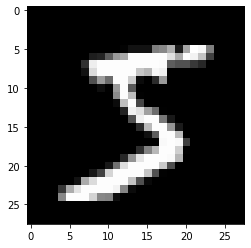

In [5]:
x = train_dataset[0][0]
print(x.shape)
plt.imshow(x.squeeze().numpy(), cmap="gray")
plt.show()

## Splitting data

Sometimes, we might need to split the data (usually to get validation dataset).

PyTorch provides [`torch.utils.data.random_split`](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split) for those cases:

In [6]:
train_dataset, validation_dataset = torch.utils.data.random_split(
    train_dataset, [50000, 10000]
)  # split into 50K training & 10K validation

## Dataloaders

Below, dataloaders are created as a dictionary; you may sometimes see this approach:
- Pros:
    - easier to read (instead of `training_dataloader`)
    - easier to use
- Cons:
    - still a lot of repetition

In [7]:
BATCH_SIZE = 64

dataloaders = {
    "train": torch.utils.data.DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        pin_memory=torch.cuda.is_available(),
    ),
    "validation": torch.utils.data.DataLoader(
        validation_dataset, batch_size=BATCH_SIZE, pin_memory=torch.cuda.is_available()
    ),
    "test": torch.utils.data.DataLoader(
        test_dataset, batch_size=BATCH_SIZE, pin_memory=torch.cuda.is_available()
    ),
}

## Exercise

Add code to a `Runner` class which will wrap training of provided model
(as always, add your code where `...` are located):

- `evaluate` method:
    - Iterate over dataloader
    - Cast both `X` and `y` to `self.device` (see previous notebook if needed)
    - Get outputs from model
    - Pass `outputs` and `y` to `self.feed_metrics` function
    
- `train` method:
    - Iterate over dataloader
    - Cast both `X` and `y` to `self.device` (see previous notebook if needed)
    - Get outputs from model
    - Calculate loss using `self.criterion`
    - Backpropagate through graph
    - Take step of `self.optimizer` and zero it's gradient using `zero_grad`
    - Pass `outputs` and `y` to `self.feed_metrics` function
    
After that fill `Accuracy`'s `forward` method which calculates __multiclass accuracy__ from outputted `logits` and integer-encoded labels. You should return a single scalar value.

__Tips:__
- `torch.argmax`
- cast to `float` after comparison
- __remember to take `torch.mean` of the value__

In [8]:
import dataclasses


@dataclasses.dataclass
class Runner:
    model: torch.nn.Module
    criterion: typing.Callable[[torch.Tensor, torch.Tensor], torch.Tensor]
    optimizer: torch.optim.Optimizer
    device: torch.device
    metrics: typing.Iterable[
        typing.Callable[[torch.Tensor, torch.Tensor], torch.Tensor]
    ]

    def feed_metrics(self, outputs, y):
        for metric in self.metrics:
            metric(outputs, y)

    def print_metrics(self):
        for metric in self.metrics:
            print(f"{metric.__class__.__name__}: {metric.evaluate()}")

    def evaluate(self, dataloader):
        self.model.eval()
        with torch.no_grad():
            for X, y in dataloader:
                X, y = X.to(self.device), y.to(self.device)
                outputs = self.model(X)
                self.feed_metrics(outputs, y)
        self.print_metrics()

    def train(self, dataloader):
        self.model.train()
        for X, y in dataloader:
            X, y = X.to(self.device), y.to(self.device)
            outputs = self.model(X)
            loss = self.criterion(outputs, y)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            self.feed_metrics(outputs, y)
        self.print_metrics()

In [9]:
class Metric:
    def __init__(self):
        self.cache = 0
        self.i = 0

    def __call__(self, logits, labels):
        self.i += 1
        self.cache += self.forward(logits.detach(), labels)

    def evaluate(self):
        result = self.cache / self.i
        self.cache = 0
        self.i = 0
        return result


class CrossEntropyLoss(Metric):
    def forward(self, logits, labels):
        return torch.nn.functional.cross_entropy(logits, labels, reduction="mean")

class Accuracy(Metric):
    def forward(self, logits, labels):
        return torch.mean((torch.argmax(logits, dim=-1) == labels).float())

## Results

Let's see our first neural network classifier of MNIST digits!

In [ ]:
EPOCHS = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1),
    torchvision.models.resnet18(num_classes=10),
).to(device)
runner = Runner(
    model,
    torch.nn.CrossEntropyLoss(),
    torch.optim.Adam(model.parameters(), lr=3e-4),
    device,
    [Accuracy(), CrossEntropyLoss()],
)

for epoch in range(EPOCHS):
    print(f"===================== EPOCH {epoch} ===================")
    print(f"=================== TRAINING ====================")
    runner.train(dataloaders["train"])
    print(f"================== VALIDATION ===================")
    runner.evaluate(dataloaders["validation"])
    print(f"===================== TEST ======================")
    runner.evaluate(dataloaders["test"])

===================== EPOCH 0 ===================
=================== TRAINING ====================
Accuracy: 0.9571411609649658
CrossEntropyLoss: 0.14016668498516083
================== VALIDATION ===================
Accuracy: 0.9788017868995667
CrossEntropyLoss: 0.07143910974264145
===================== TEST ======================
Accuracy: 0.9794984459877014
CrossEntropyLoss: 0.06106313690543175
===================== EPOCH 1 ===================
=================== TRAINING ====================


## Summary

- In PyTorch we create datasets by inheriting from `torch.utils.data.Dataset`:
    - those return a single item during each iteration
    - really simple & lightweight abstraction
- `torch.utils.DataLoader` takes care of:
    - batching
    - shuffling
    - speed ups when loading data
- __You should always provide your dataset instance to `DataLoader`!__
- `torchvision` is part of PyTorch project and provides:
    - datasets
    - transformations
    - vision related models
- Default `pytorch` requires a lot of boilerplate code but is a battle-tested approach to training neural networks

## Challenges

- what are [IterableDatasets](https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset)? Where those might be used?
- read more about [Memory Pinning](https://pytorch.org/docs/stable/data.html#memory-pinning)
- check out third party module [torchdata](https://github.com/szymonmaszke/torchdata) for other ways to handle caching and data transformations of PyTorch's `Dataset`
- go over PyTorch's [data documentation](https://pytorch.org/docs/stable/data.html) and learn a little more about the details